Calef
**Question:** What student habits are the strongest predictors of academic performance (exam score), and are these predictors consistent across genders?


**Variables involved:**  exam_score (continuous), age (continuous), gender (categorical), study_hours_per_day (continuous), social_media_hours (continuous), netflix_hours (continuous), part_time_job (binary), attendance_percentage (continuous), sleep_hours (continuous), diet_quality (categorical), exercise_frequency (continuous), parental_education_level (categorical), internet_quality (categorical), mental_health_rating (continuous), extracurricular_participation (binary)


**Cleaning:** Missing values will be dropped. Categorical variables (gender, diet_quality, parental_education_level, internet_quality, part_time_job, and extracurricular_participation) will be dummied using get_dummies.


**Modeling/Computation:** An 80/20 Train/Test split will be used. All continuous variables will be standardized using z-scores. A linear regression model will be trained to predict exam_score using all variables. Dimensionality reduction will be performed using Lasso regression to identify the most important predictors. The same process will be repeated for each gender subgroup (male, female, other) to assess whether the strongest predictors are consistent across genders.


**Graphs:** A bar chart showing Lasso coefficients for all predictors in the full dataset. Side-by-side coefficient bar charts for each gender subgroup to visualize consistency of predictor importance. Scatterplots or boxplots of the top predictors (e.g., study_hours_per_day, attendance_percentage) vs. exam_score, with color indicating gender.


In [3]:
# data imports
import pandas as pd
import numpy as np
from plotnine import *

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn.metrics import r2_score, mean_absolute_error


# read in data
df = pd.read_csv("student_habits_performance.csv")
df.head()

# check for missing values
df.isnull().sum()

# drop missing values and fix index
df.dropna(inplace=True)
df.reset_index(inplace=True)

# check dropped
df.isnull().sum()

# one-hot encode categorical variables
categorical_vars = ['gender', 'diet_quality', 'parental_education_level',
                    'internet_quality', 'part_time_job', 'extracurricular_participation']

df_encoded = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# drop identifier of student id
df_encoded = df_encoded.drop(columns=['student_id'])

# train test split (80/20)
X = df_encoded.drop(columns=['exam_score'])
y = df_encoded['exam_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Z-Score continuous variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Lasso Regression
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)


,eps,0.001
,n_alphas,'deprecated'
,alphas,'warn'
,fit_intercept,True
,precompute,'auto'
,max_iter,1000
,tol,0.0001
,copy_X,True
,cv,5
,verbose,False
,n_jobs,None


In [4]:
# Evaluation
y_pred_lr = lr.predict(X_test_scaled)
y_pred_lasso = lasso.predict(X_test_scaled)

print("Linear Regression Performance:")
print("  R²:", r2_score(y_test, y_pred_lr))
print("  MAE:", mean_absolute_error(y_test, y_pred_lr))

print("\nLasso Regression Performance:")
print("  R²:", r2_score(y_test, y_pred_lasso))
print("  MAE:", mean_absolute_error(y_test, y_pred_lasso))

Linear Regression Performance:
  R²: 0.8890976884915165
  MAE: 4.257508805159324

Lasso Regression Performance:
  R²: 0.8914100545227194
  MAE: 4.208957347069619


In [5]:
# top predictors

# dataframe of coefficients
lasso_df = pd.DataFrame({
    'predictor': X.columns,
    'coefficient': lasso.coef_
})

top_predictors = lasso_df[lasso_df['coefficient'] != 0].copy()
top_predictors['abs_coeff'] = top_predictors['coefficient'].abs()
top_predictors = top_predictors.sort_values(by='abs_coeff', ascending=False)

print(top_predictors[['predictor', 'coefficient']].head(10))


                predictor  coefficient
2     study_hours_per_day    14.124174
8    mental_health_rating     5.488222
7      exercise_frequency     2.929224
3      social_media_hours    -2.884108
6             sleep_hours     2.243507
4           netflix_hours    -2.116434
5   attendance_percentage     1.427585
11      diet_quality_Good    -0.155743
0                   index    -0.056958


Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


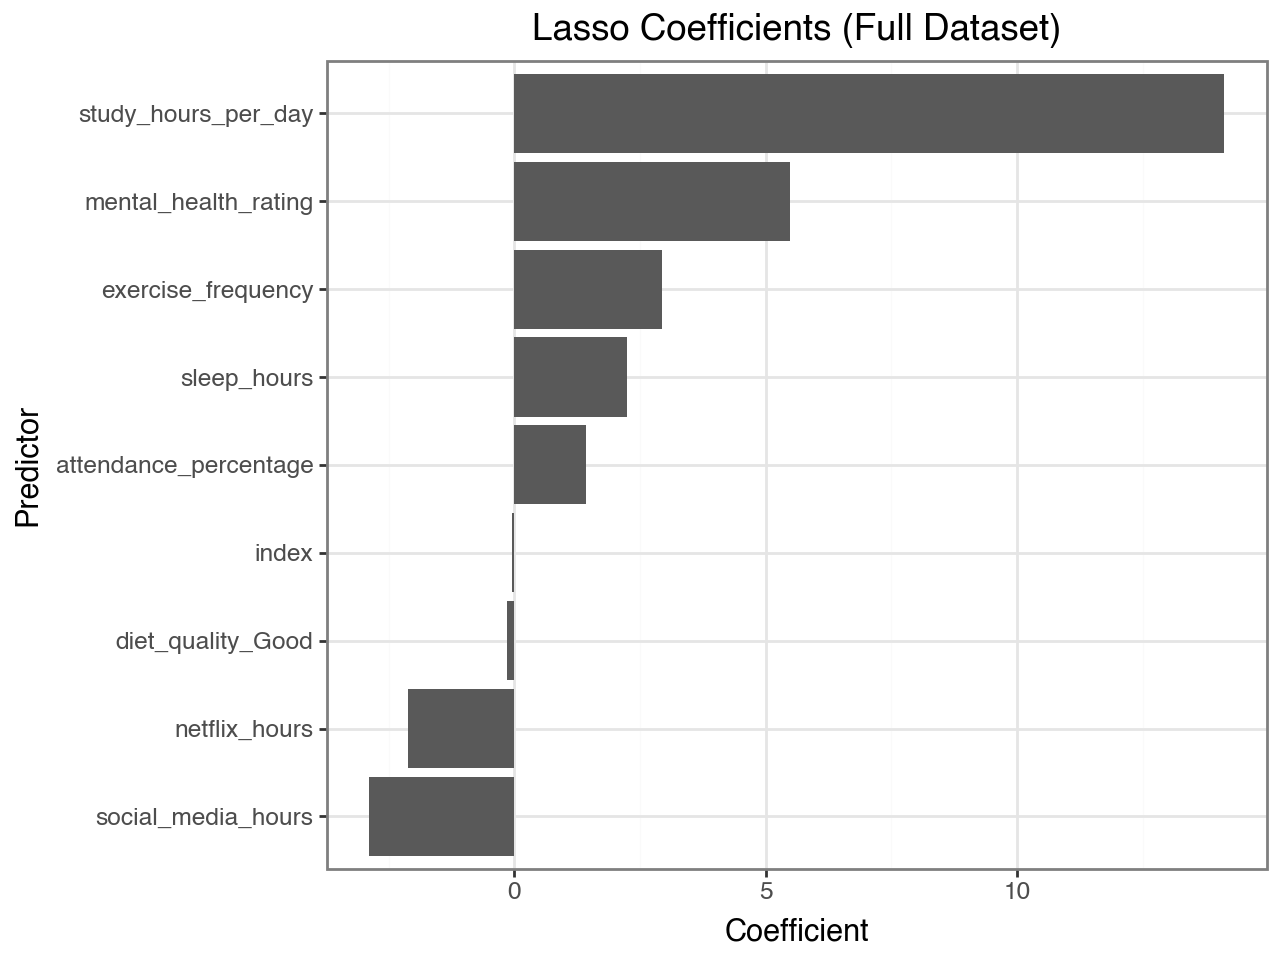

In [6]:
# ggplot 1: LASSO bar chart

## CHAT GPT prompt: how to graph lasso coefficients as a bar chart ##
display(ggplot(lasso_df[lasso_df['coefficient'] != 0], aes(x='reorder(predictor, coefficient)', y='coefficient')) +
    geom_bar(stat='identity') +
    coord_flip() +
    labs(title='Lasso Coefficients (Full Dataset)', x='Predictor', y='Coefficient') +
    theme_bw())
## end code from CHAT GPT ##

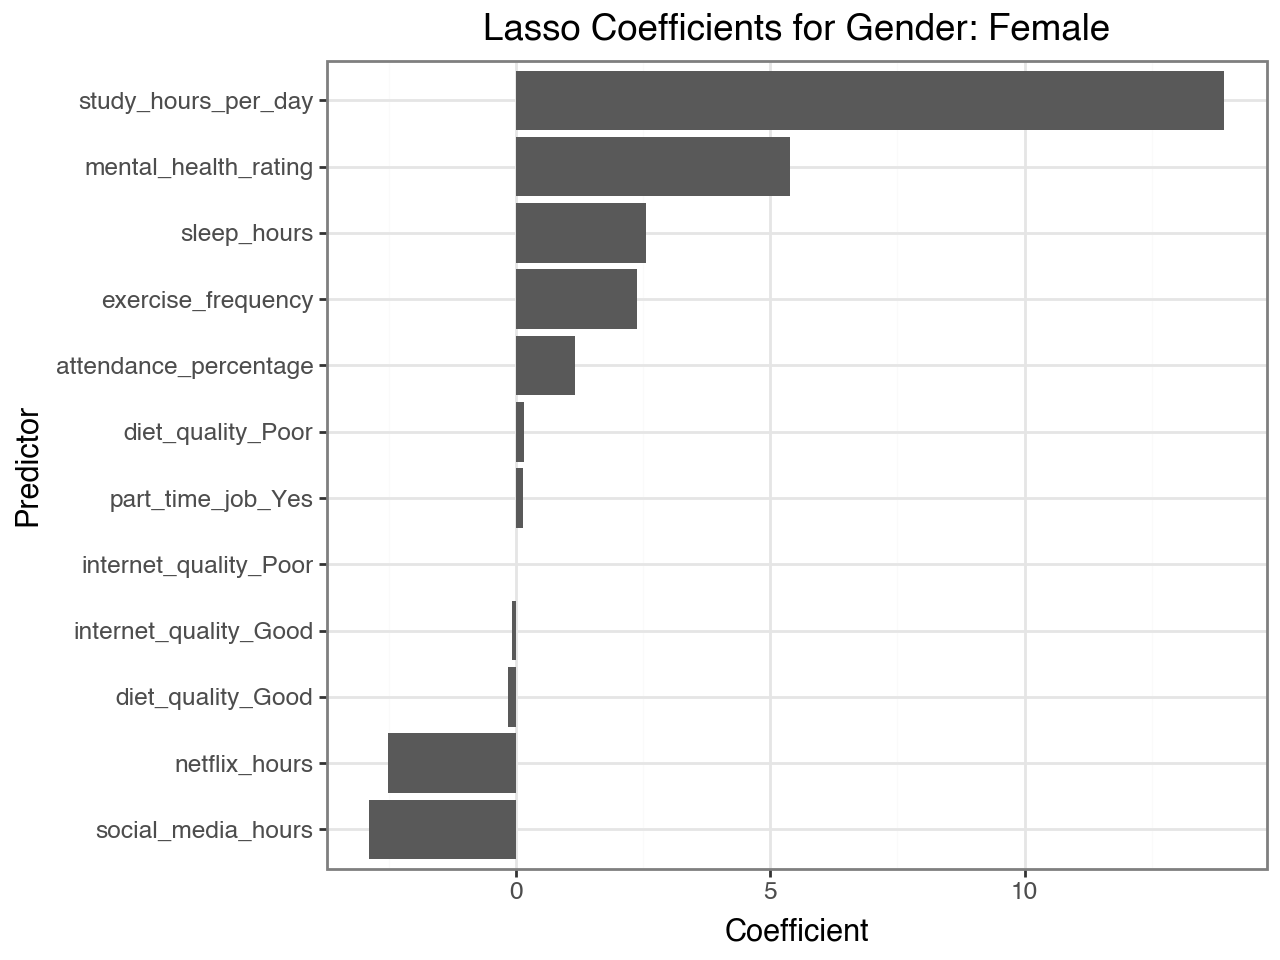

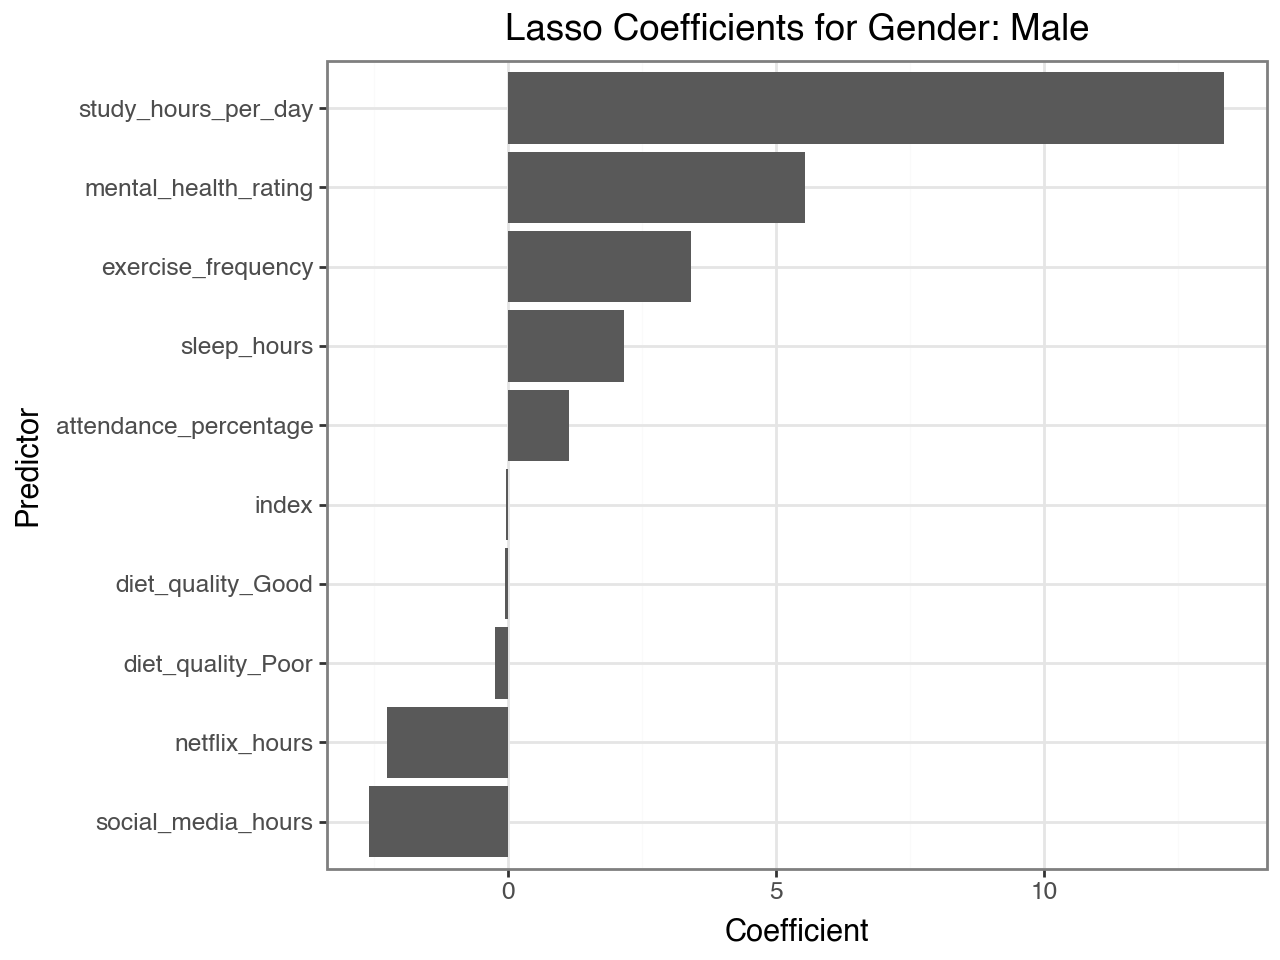

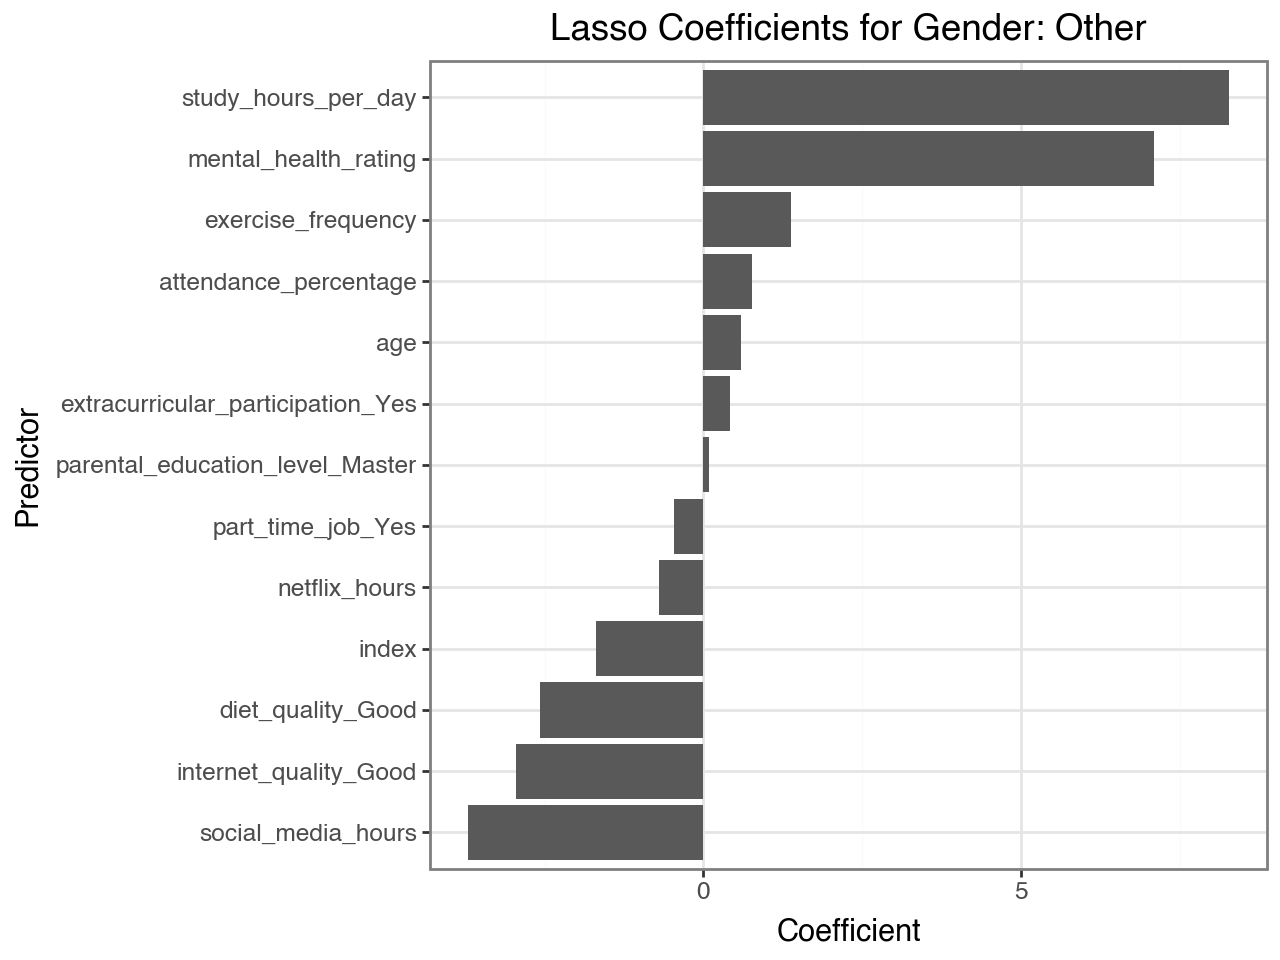

In [7]:
# ggplot 2: Gender Subgroups

genders = df['gender'].unique()

# loop through each gender to create plot
for gender in genders:
    df_gender = df[df['gender'] == gender].copy()
    df_gender = pd.get_dummies(df_gender, columns=categorical_vars, drop_first=True)

    # remove student id
    if 'student_id' in df_gender.columns:
        df_gender.drop(columns=['student_id'], inplace=True)

    X_g = df_gender.drop(columns=['exam_score'])
    y_g = df_gender['exam_score']

    if len(X_g) < 10:
        continue  # skip if not enough data

    X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_g, y_g, test_size=0.2, random_state=42)
    X_train_g_scaled = scaler.fit_transform(X_train_g)

    lasso_g = LassoCV(cv=5, random_state=42)
    lasso_g.fit(X_train_g_scaled, y_train_g)

    lasso_df_g = pd.DataFrame({
        'predictor': X_g.columns,
        'coefficient': lasso_g.coef_
    })


    plot = (
        ggplot(lasso_df_g[lasso_df_g['coefficient'] != 0], aes(x='reorder(predictor, coefficient)', y='coefficient')) +
        geom_bar(stat='identity') +
        coord_flip() +
        labs(title=f'Lasso Coefficients for Gender: {gender}', x='Predictor', y='Coefficient') +
        theme_bw()
    )


    display(plot)

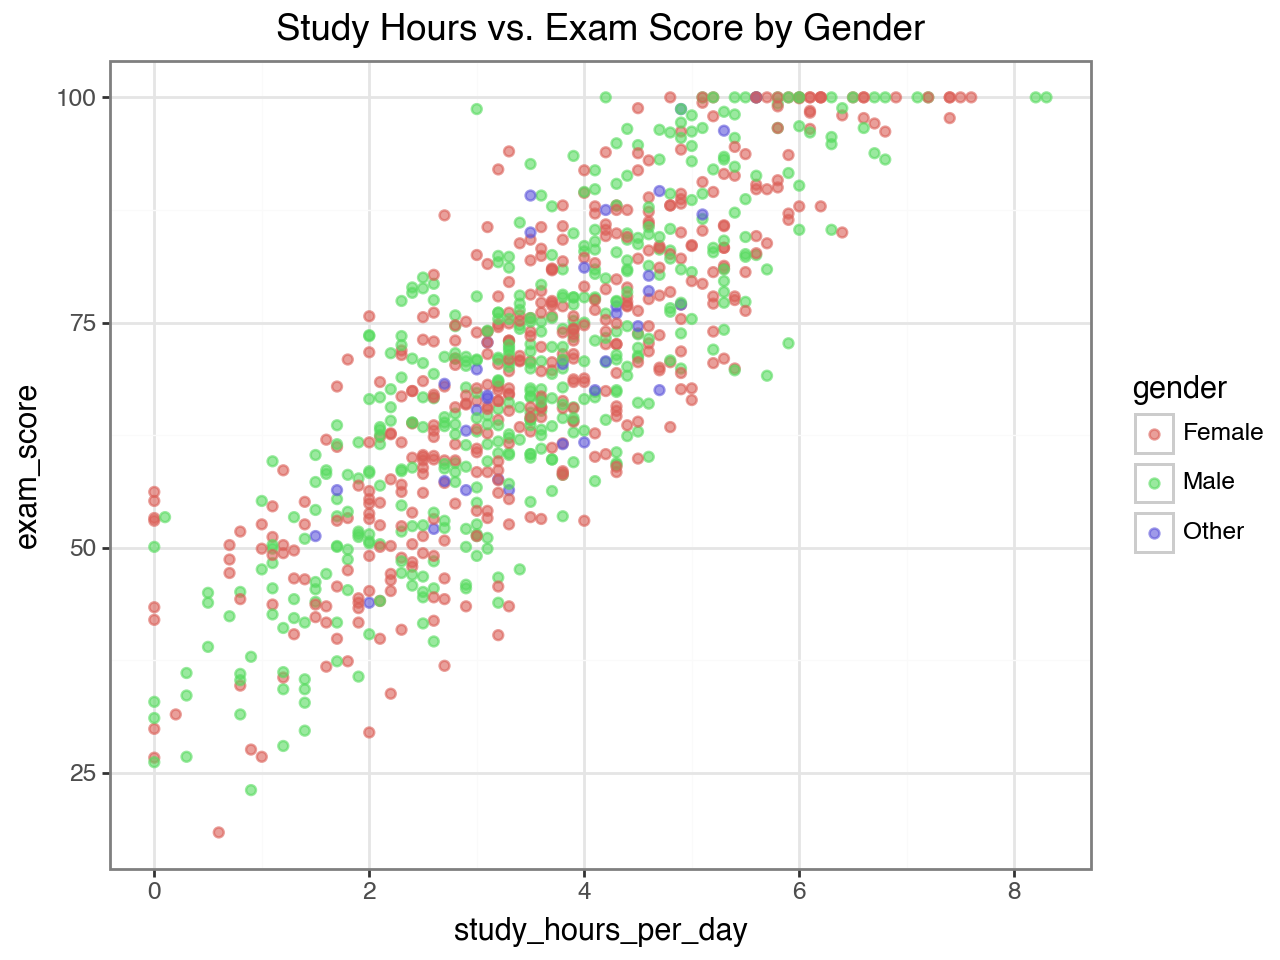

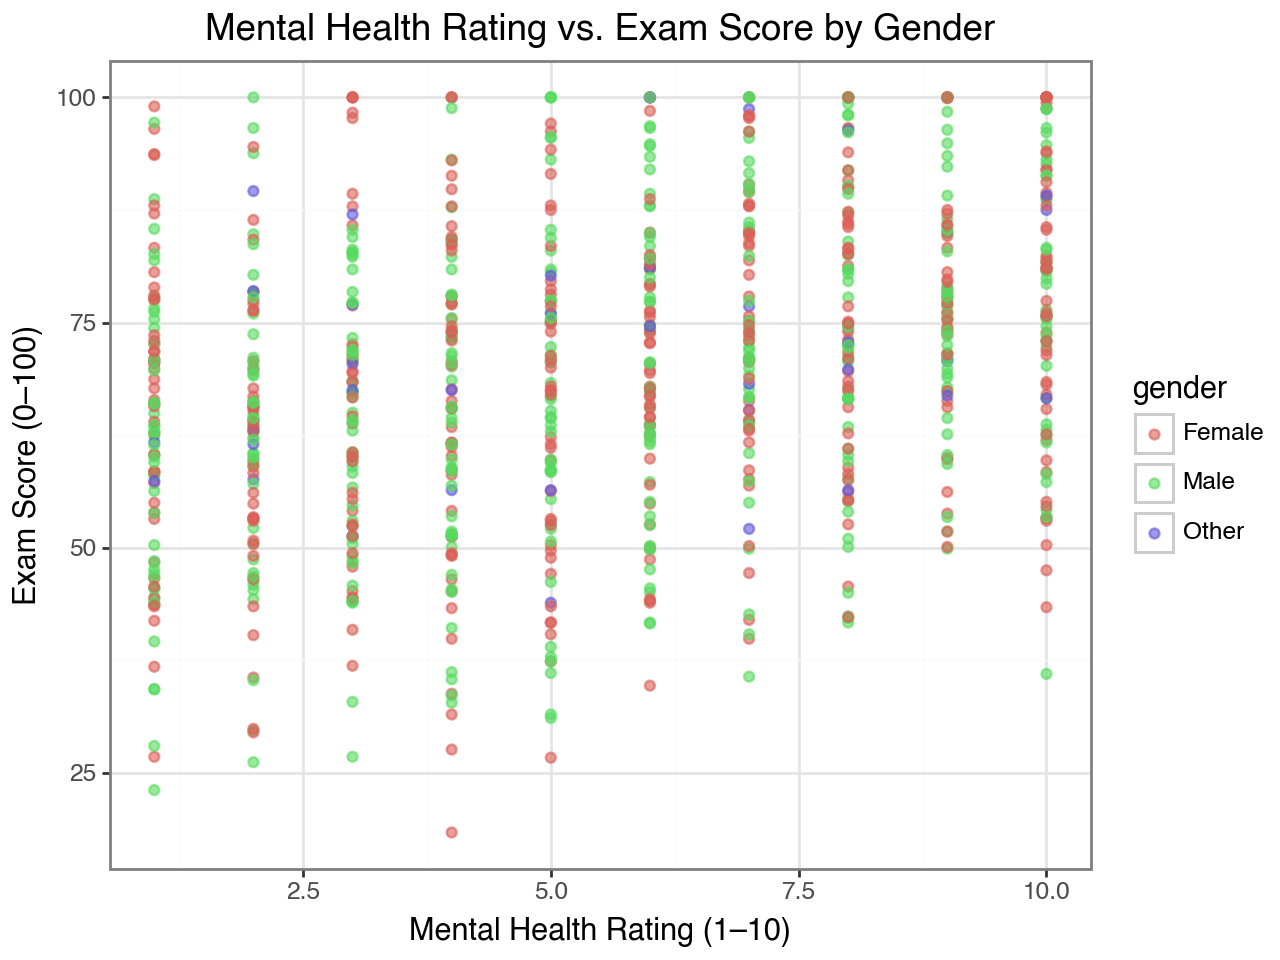

In [8]:
# ggplot 3: top 2 predictors

display(ggplot(df, aes(x='study_hours_per_day', y='exam_score', color='gender')) +
    geom_point(alpha=0.6) +
    labs(title='Study Hours vs. Exam Score by Gender') +
    theme_bw())

display(
    ggplot(df, aes(x='mental_health_rating', y='exam_score', color='gender')) +
    geom_point(alpha=0.6) +
    labs(title='Mental Health Rating vs. Exam Score by Gender',
         x='Mental Health Rating (1–10)',
         y='Exam Score (0–100)') +
    theme_bw()
)

Calef
Q2


**Question:** When clustering students based on their average study hours per week, sleep hours per night, and social media usage, what clusters emerge, and how do these clusters differ in terms of average academic performance?


**Variables involved:**  study_hours_per_day (continuous), sleep_hours (continuous), social_media_hours (continuous), exam_score (continuous; used only for comparing clusters)


**Cleaning:**  Missing values will be dropped. Only the variables study_hours_per_day, sleep_hours, and social_media_hours will be used to create the clusters. These continuous variables will be z-scored before clustering.


**Modeling/Computation:** K-Means clustering will be used to group students based on study habits (study_hours_per_day, sleep_hours, social_media_hours). The optimal number of clusters will be chosen using the elbow method or silhouette score. Once clusters are assigned, average exam_score will be calculated and compared across clusters to identify performance differences.


**Graphs:** A 2D scatter plot of the clusters (using PCA for dimensionality reduction if needed), colored by cluster. A bar chart showing the average exam score for each cluster.

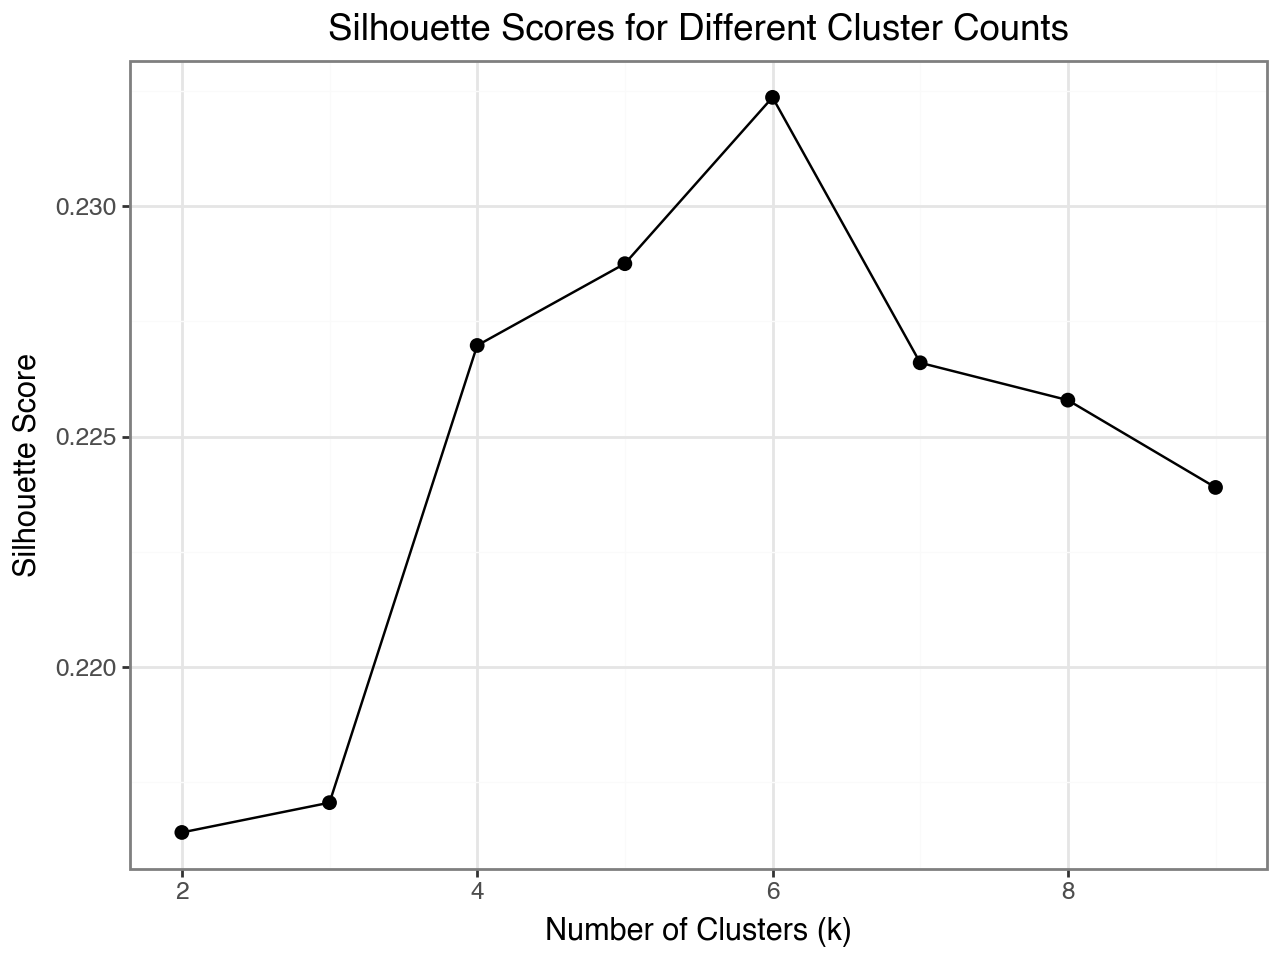

In [10]:
# extra imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# load and clean data
df2 = pd.read_csv("student_habits_performance.csv")
df2.dropna(subset=['study_hours_per_day', 'sleep_hours', 'social_media_hours', 'exam_score'], inplace=True)

features = ['study_hours_per_day', 'sleep_hours', 'social_media_hours']
X = df2[features]
X_scaled = StandardScaler().fit_transform(X)

# silhouette scores
silhouette_data = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_data.append({'k': k, 'silhouette': score})

sil_df = pd.DataFrame(silhouette_data)

# plot scores
display(ggplot(sil_df, aes(x='k', y='silhouette')) +
    geom_line() +
    geom_point(size=2) +
    labs(title='Silhouette Scores for Different Cluster Counts',
         x='Number of Clusters (k)',
         y='Silhouette Score') +
    theme_bw())

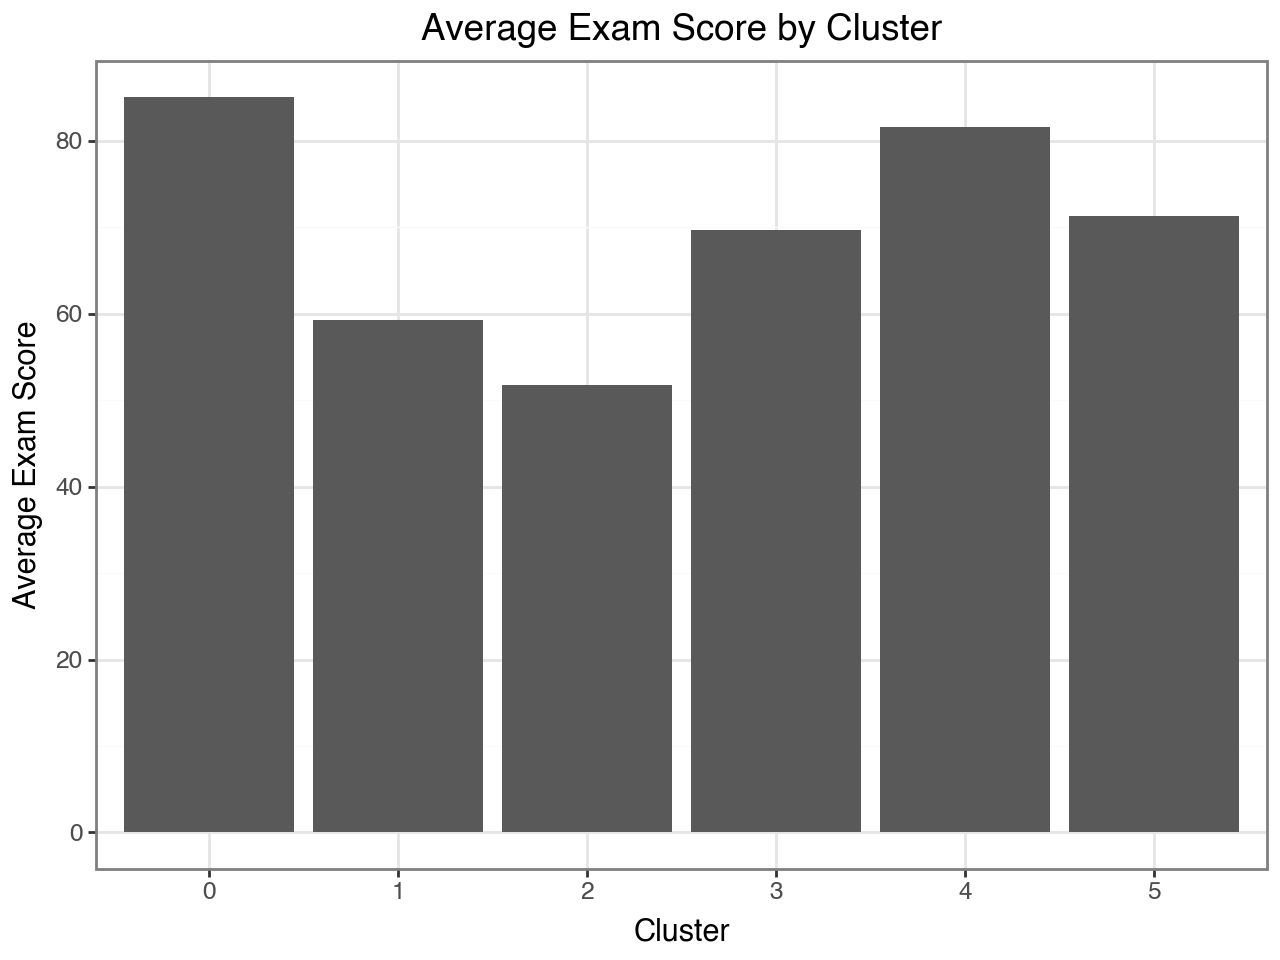

In [16]:
# fit final model
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
df2['cluster'] = kmeans.fit_predict(X_scaled).astype(str)

# average exam score
cluster_avg = df2.groupby('cluster')['exam_score'].mean().reset_index()

# ggplot
display(ggplot(cluster_avg, aes(x='cluster', y='exam_score')) +
    geom_bar(stat='identity') +
    labs(title='Average Exam Score by Cluster',
         x='Cluster',
         y='Average Exam Score') +
    theme_bw())

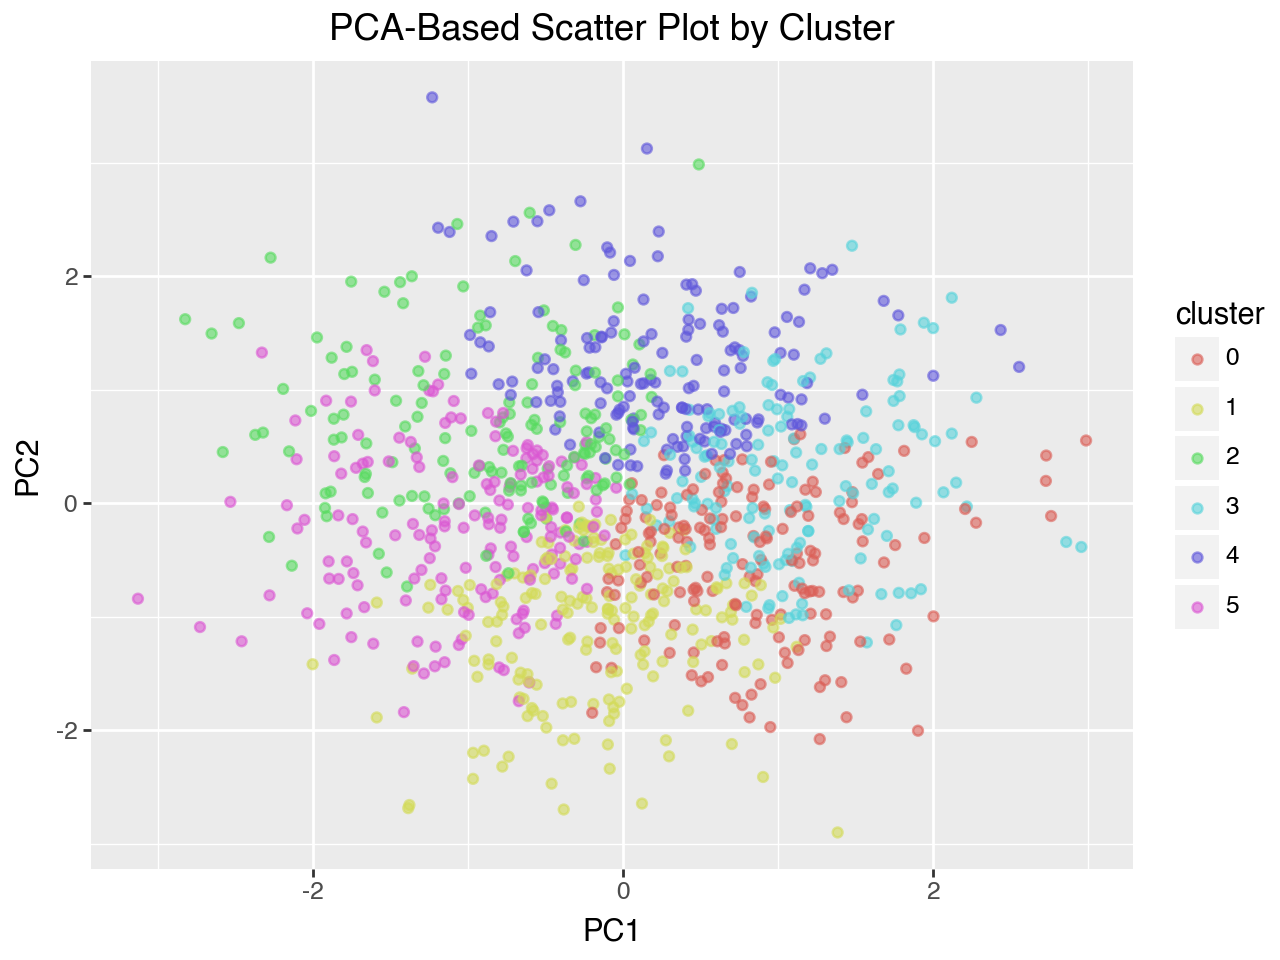

In [19]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)
df2['PC1'] = pca_coords[:, 0]
df2['PC2'] = pca_coords[:, 1]

# Plot PCA-based scatter by cluster
display(ggplot(df2, aes(x='PC1', y='PC2', color='cluster')) +
    geom_point(alpha=0.6) +
    labs(title='PCA-Based Scatter Plot by Cluster'))

In [21]:
# summary to show how clusters are made up

features = ['study_hours_per_day', 'sleep_hours', 'social_media_hours']
cluster_summary = df2.groupby('cluster')[features].mean().round(2)

display(cluster_summary)

,study_hours_per_day,sleep_hours,social_media_hours
cluster,,,
0,4.98,6.07,1.57
1,2.48,5.68,1.71
2,2.07,6.91,3.61
3,4.01,5.01,3.45
4,4.87,7.32,3.39
5,3.08,7.82,1.66


Sam Q3 ** make a new column to note whether a students exam score is above/below mean

**Question:** Looking at the coefficients of a logistic regression model, which student habit variables have the strongest relationship with whether student scores above or below the average exam score?

**Variables involved:** student_hours_per_day (continuous), social_media_hours (continuous), netflix_hours (continuous), attendance_percentage (continuous), sleep_hours (continuous), diet_quality (categorical), exercise_frequency (continuous), extracurricular_participation (binary)  

**Cleaning**:  Missing values will be dropped. Categorical variables (diet_quality,  extracurricular_participation) will be dummied using get_dummies.

**Modeling/Computation:** An 80/20 Train/Test split will be used. All continuous variables will be standardized using z-scores. A logistic regression model will be trained to predict whether a student scored above an average exam score. Standardized coefficients will be examined to determine which habits are most strongly correlated with above-average exam scores. Absolute coefficient magnitudes will be used to assess which variables are important.

**Graphs:** A bar chart showing the absolute values of standardized logistic regression coefficients for each student habit variable highlighting which habits have the strongest positive or negative correlation. A box plot would be able to compare the distribution of the strongest habit variable (study_hours_per_day) between students who scored above the average exam score and those who did not to visualize the variable’s impact.

**Brief discussion of why analysis is effective at answering question:** This analysis is effective because it uses Logistic Regression to measure the impact of which student habits affect the likelihood of scoring above the average exam score. By standardizing the predictors, we can compare the coefficient effectiveness to determine which habits have the strongest influence. The graph visualizes the results by showing the relationship between the student habits and performance.


In [24]:
# imports
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score

# read in data
df3 = pd.read_csv("student_habits_performance.csv")
df3.head()

# check for missing values
df3.isnull().sum()

# drop missing values and fix index
df3.dropna(inplace=True)
df3.reset_index(inplace=True)

# check dropped
df3.isnull().sum()

# make binary target column whether the exam score is above the mean
mean_score = df3['exam_score'].mean()
df3['above_average'] = (df3['exam_score'] > mean_score).astype(int)

# variables
vars = ['study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage', 'sleep_hours', 'diet_quality', 'exercise_frequency', 'extracurricular_participation']

# One-hot encode categorical variables
df3_model = pd.get_dummies(df3[vars + ['above_average']], columns = ['diet_quality', 'extracurricular_participation'], drop_first = True)

# Train-test-split
X1 = df3_model.drop(columns=['above_average'])
y1 = df3_model['above_average']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Z-Score continuous variables
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X1_train_scaled, y1_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [25]:
# predicitions and probabilities
y1_train_pred = logreg.predict(X1_train_scaled)
y1_test_pred = logreg.predict(X1_test_scaled)

y1_train_proba = logreg.predict_proba(X1_train_scaled)[:, 1]
y1_test_proba = logreg.predict_proba(X1_test_scaled)[:, 1]

# Evaluation
print("Logistic Regression Evaluation")

# Training Set
print("Training Set: ")
print("  Accuracy:", accuracy_score(y1_train, y1_train_pred))
print("  Recall:", recall_score(y1_train, y1_train_pred))
print("  Precision:", precision_score(y1_train, y1_train_pred))
print("  ROC AUC:", roc_auc_score(y1_train, y1_train_proba))

# Test Set
print("Test Set: ")
print("  Accuracy:", accuracy_score(y1_test, y1_test_pred))
print("  Recall:", recall_score(y1_test, y1_test_pred))
print("  Precision:", precision_score(y1_test, y1_test_pred))
print("  ROC AUC:", roc_auc_score(y1_test, y1_test_proba))

Logistic Regression Evaluation
Training Set: 
  Accuracy: 0.8376891334250344
  Recall: 0.8387096774193549
  Precision: 0.8432432432432433
  ROC AUC: 0.9329092836589429
Test Set: 
  Accuracy: 0.8131868131868132
  Recall: 0.7777777777777778
  Precision: 0.8651685393258427
  ROC AUC: 0.9145673603504929


In [26]:
# top predictors

# dataframe of coefficients
coefficients_df3 = pd.DataFrame({
    'Variable': X1.columns,
    'Coefficient': logreg.coef_[0]
})
logreg_abs_coefficients = coefficients_df3.copy()
logreg_abs_coefficients['abs_coefficient'] = logreg_abs_coefficients['Coefficient'].abs()
logreg_abs_coefficients

# top 10 coefficients
print("Top Logistic Regression Predictors: ")
print(logreg_abs_coefficients.sort_values(by='abs_coefficient', ascending=False).head(10))

Top Logistic Regression Predictors: 
                            Variable  Coefficient  abs_coefficient
0                study_hours_per_day     3.015229         3.015229
5                 exercise_frequency     0.653732         0.653732
1                 social_media_hours    -0.653614         0.653614
4                        sleep_hours     0.576805         0.576805
2                      netflix_hours    -0.549106         0.549106
3              attendance_percentage     0.449950         0.449950
6                  diet_quality_Good    -0.171464         0.171464
7                  diet_quality_Poor    -0.021662         0.021662
8  extracurricular_participation_Yes     0.017310         0.017310


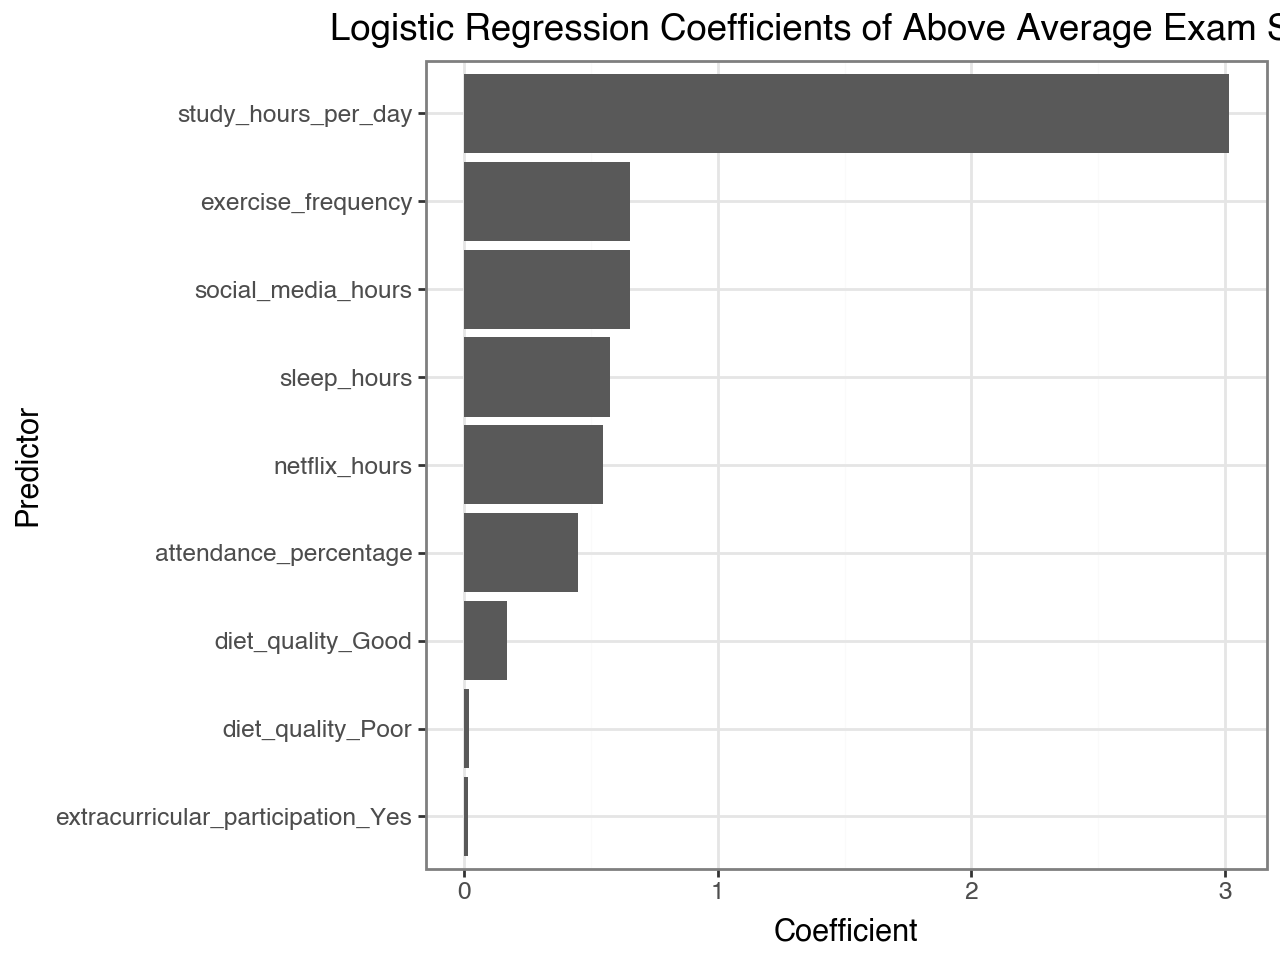

In [27]:
# bar chart of coefficients
display(ggplot(logreg_abs_coefficients.sort_values(by='abs_coefficient', ascending=False), aes(x='reorder(Variable, abs_coefficient)', y='abs_coefficient')) +
        geom_bar(stat='identity') +
    coord_flip() +
    labs(title='Logistic Regression Coefficients of Above Average Exam Score', x='Predictor', y='Coefficient') +
    theme_bw())

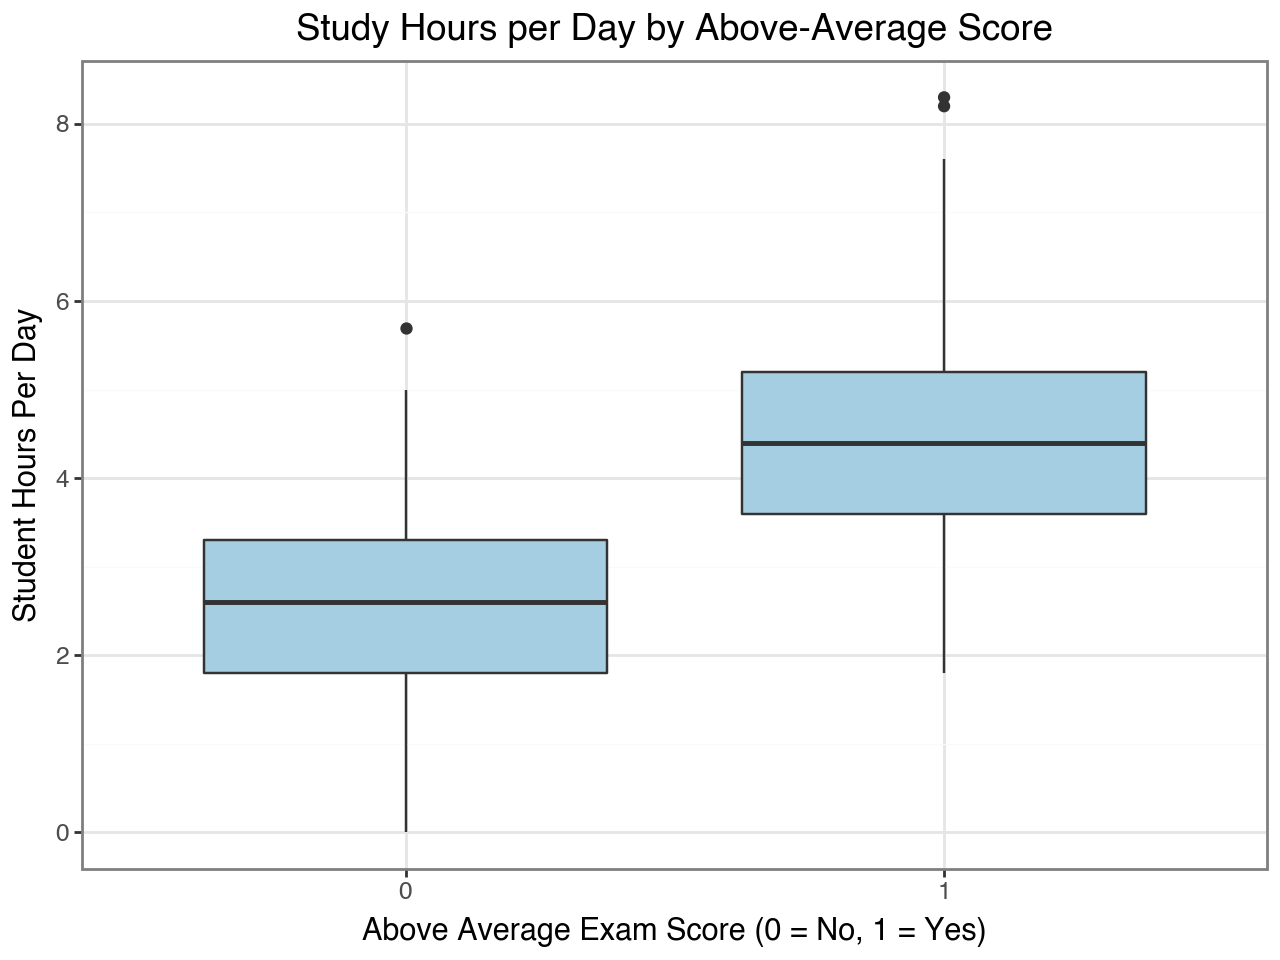

In [28]:
# Asked ChatGPT to help me create a Box Plot of the Strongest Predictor being study_hours_per_day
display(
    ggplot(df3, aes(x='factor(above_average)', y='study_hours_per_day')) +
    geom_boxplot(fill='#a6cee3') +
    labs(title='Study Hours per Day by Above-Average Score',
         x='Above Average Exam Score (0 = No, 1 = Yes)',
         y='Student Hours Per Day') +
    theme_bw()
)

# End of ChatGPT

Sam Q4

**Question:** How does having a part time job (or not) affect a student’s exam scores? Is there a relationship between the two variables, and is it linear or more complex?

**Variables involved:**  exam_score (continuous), part_time_job (binary),  study_hours_per_day (continuous), sleep_hours (continuous), attendance_percentage (continuous),  mental_health_rating (continuous)

**Cleaning**:  Missing values will be dropped. The binary variable (part_time_job) will remain and there are no categorical variables to get dummied.

**Modeling/Computation:** An 80/20 Train/Test split will be used. All continuous variables will be z-scored. Two linear regression models will be trained to predict exam_score. One model using the variable part_time_job to predict its relationship with exam performance. The other model uses all the variables to evaluate whether the effect of part-time work persists when accounting for other academic and wellness factors. Compare the R^2 scores for both models on training and test sets to assess the added value of including other variables. Look for the model assumptions (linearity, homoscedasticity, etc) to validate fit.

**Graphs:** A box plot of exam_score grouped by part_time_job to assess the differences in average performance between students who work and those who do not. A scatter plot of study_hours_per_day vs. exam_score, with a color key coded by part_time_job, to assess the relationship between study time and performance compared to working vs. non-working students. If a non-linear trend is caught, you can conclude there is a more complex relationship.

**Brief discussion of why analysis is effective at answering question:**This analysis is effective as it isolates the impact of part-time work on exam performance using linear regression models and compares the two models to determine whether having a job has an independent effect or if other factors play a role. The visualizations allow us to analyze these relationships to see if there is a linear relationship or a more complex one. The graphs visualize how part-time employment influences academic outcomes.


In [30]:
# imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
# read in data
df4 = pd.read_csv("student_habits_performance.csv")
df4.head()

# check for missing values
df4.isnull().sum()

# drop missing values and fix index
df4.dropna(inplace=True)
df4.reset_index(inplace=True)

# check dropped
df4.isnull().sum()

# variables
predictors = ['exam_score', 'part_time_job', 'study_hours_per_day', 'sleep_hours', 'attendance_percentage', 'mental_health_rating']
df4 = df4[predictors]

# X and y for Model 1 (part_time_job)
# Convert 'part_time_job' to binary (0 and 1) <-- suggestion to fix when came up with error
df4['part_time_job'] = df4['part_time_job'].map({'No': 0, 'Yes': 1})  # Map 'No' to 0 and 'Yes' to 1
X2 = df4[['part_time_job']]  # Use double brackets to create a DataFrame for X2
y2 = df4['exam_score']

# train-test-split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# fit model 1
lr1 = LinearRegression()
lr1.fit(X2_train, y2_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [31]:
# predict and evaluate Model 1
y2_train_pred = lr1.predict(X2_train)
y2_test_pred = lr1.predict(X2_test)

print("Model 1: Exam Score vs. Part-Time Job")
print("Training Set:")
print("  R²:", r2_score(y2_train, y2_train_pred))
print("  MAE:", mean_absolute_error(y2_train, y2_train_pred))

print("\nTest Set:")
print("  R²:", r2_score(y2_test, y2_test_pred))
print("  MAE:", mean_absolute_error(y2_test, y2_test_pred))

Model 1: Exam Score vs. Part-Time Job
Training Set:
  R²: 0.00042785452908356003
  MAE: 13.700006885200485

Test Set:
  R²: -0.012165668043912392
  MAE: 13.523271970054799


In [32]:
# Model 2 with additional predictors
X3 = df4.drop(columns=['exam_score'])
continuous_predictors = ['study_hours_per_day', 'sleep_hours', 'attendance_percentage', 'mental_health_rating']
y3 = df4['exam_score']

# z-score continuous variables
scaler = StandardScaler()
X3[continuous_predictors] = scaler.fit_transform(X3[continuous_predictors])

# train-test-split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

# fit model 2
lr3 = LinearRegression()
lr3.fit(X3_train, y3_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [33]:
# predict and evaluate Model 2
y3_train_pred = lr3.predict(X3_train)
y3_test_pred = lr3.predict(X3_test)

print("Model 2: Exam Score vs. Part-Time Job + Academic & Wellness Predictors")
print("Training Set:")
print("  R²:", r2_score(y3_train, y3_train_pred))
print("  MAE:", mean_absolute_error(y3_train, y3_train_pred))

print("\nTest Set:")
print("  R²:", r2_score(y3_test, y3_test_pred))
print("  MAE:", mean_absolute_error(y3_test, y3_test_pred))

Model 2: Exam Score vs. Part-Time Job + Academic & Wellness Predictors
Training Set:
  R²: 0.8150806190124363
  MAE: 5.9003020800947175

Test Set:
  R²: 0.8094940996264433
  MAE: 5.724853420781557


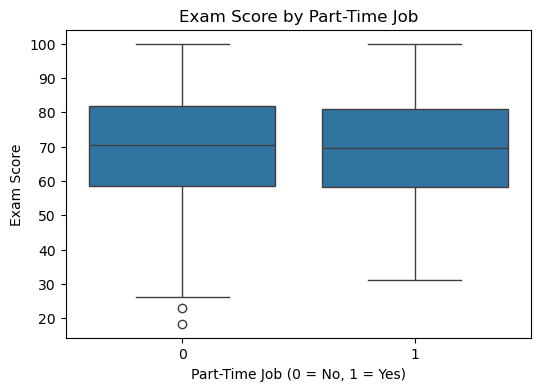

In [35]:
# Asked ChatGPT to how to graph the models of one predictor vs all

# additional imports
import seaborn as sns
import matplotlib.pyplot as plt

# Box Plot of Exam score vs. Part-Time Job
plt.figure(figsize=(6,4))
sns.boxplot(x='part_time_job', y='exam_score', data= df4)
plt.title('Exam Score by Part-Time Job')
plt.xlabel('Part-Time Job (0 = No, 1 = Yes)')
plt.ylabel('Exam Score')
plt.show()

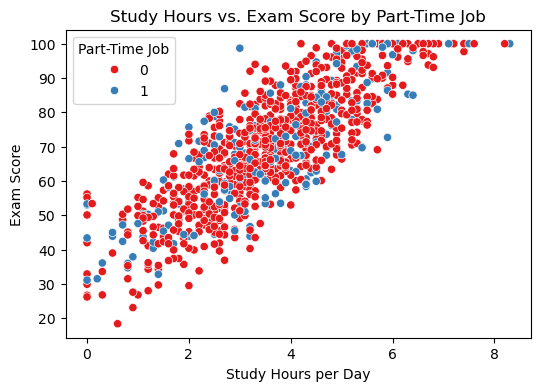

In [36]:
# scatter plot of study hours vs exam scores colored by part_time_job
plt.figure(figsize=(6,4))
sns.scatterplot(data= df4, x='study_hours_per_day', y='exam_score', hue='part_time_job', palette='Set1')
plt.title('Study Hours vs. Exam Score by Part-Time Job')
plt.xlabel('Study Hours per Day')
plt.ylabel('Exam Score')
plt.legend(title='Part-Time Job')
plt.show()

# end of ChatGPT